In [19]:
# Importing necessary libraries
# TODO:clean this
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import plot_model
# Importing necessary libraries
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'


# from transformers import SentenceTransformer
import numpy as np
import json
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from collections import OrderedDict


import pyarrow.parquet as pa

In [20]:
df = pd.read_csv('/home/mendu/Thesis/data/magnatagatune/saved_df_data/df_w_captions.csv', index_col = [0])

In [21]:
df

,mp3_path,tags,caption_writing
clip_id,,,
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the majestic beauty of classical mu...
6,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the rich sound of classical eleganc...
10,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This powerful classic opera piece showcases th...
11,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This atmospheric and introspective song blends...
14,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic,This upbeat dance track features a pulsing tec...
...,...,...,...
58896,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical guitar solo piece features intr...
58897,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This beautiful classical piece features a haun...
58898,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical piece features beautiful melodi...


## Preparing the dataloader

In [22]:
def add_gauss_noise(image, mean = 0, var = 10):
    '''function to add gaussian noise to an image'''
    sigma = var ** 0.5

    #creating a noise image with gaussian distribution
    gaussian = np.random.normal(mean, sigma, (image.shape[0], image.shape[1]))

    #creating a zeroes image
    noisy_image = np.zeros(image.shape, np.float32)

    #adding the noise to the original image
    noisy_image = image + gaussian

    #normalising the image
    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    #changing type
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

In [23]:
#loading the cropped .npy files in a tensor

#the folder path to where the mel-specs are stored
folder_path_mel = '/home/mendu/Thesis/data/magnatagatune/mel-specs'

#The ordered list of all the filenames in the filtered_df
audio_names_list = df.mp3_path.to_list()

# data = []
# i = 0

# for filename in audio_names_list: #iterates over the filtered_df audio names
#   filename_npy = str(filename[:-4]) + '.npy'
#   file_path = os.path.join(folder_path_mel, filename_npy) #creates a folder path for the mel_specs 
#   img = np.load(file_path)
#   data.append(add_gauss_noise(img))

#   # To ensure that the files are getting loaded in the correct order
#   if i < 10 :
#     print(filename)
#   i = i+1

# data = np.array(data)

data = np.load('data/magnatagatune/saved_df_data/data_array.npy')

In [24]:
#normalize data
data = data.astype('float32')/255.0

data.shape

(11826, 128, 1255)

In [25]:
# Reshape data to include the channel dimension
data = data.reshape((-1, 128, 1255, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, pd.get_dummies(df['tags']), test_size=0.1, random_state=42)

In [26]:
data.shape

(11826, 128, 1255, 1)

In [27]:
# Initialize ImageDataGenerator with necessary augmentations
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2
)

datagen.fit(X_train)

In [28]:
X_train.shape

(10643, 128, 1255, 1)

In [29]:
# Define num_classes based on the number of unique genres
num_classes = y_train.shape[1]
num_classes

8

In [30]:
# # Define the Encoder class focusing only on the encoding part
# class Encoder(nn.Module):
#     def __init__(self, input_size, encoding_size):
#         super(Encoder, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, 512),
#             nn.ReLU(True),
#             nn.BatchNorm1d(512),
#             nn.Linear(512, 256),
#             nn.ReLU(True),
#             nn.BatchNorm1d(256),
#             nn.Linear(256, 128),
#             nn.ReLU(True),
#             nn.Linear(128, encoding_size),
#             nn.ReLU(True)
#         )

#     def forward(self, x):
#         return self.layers(x)
    
# # Define input and encoding sizes
# input_size = 768
# encoding_size = 64
# def load_encoder_state_dict(encoder, state_dict_path):
#     state_dict = torch.load(state_dict_path)
#     # Rename the state_dict keys to match the structure of the Encoder class
#     new_state_dict = OrderedDict()
#     for k, v in state_dict.items():
#         # Prepend 'layers.' to each key
#         name = f'layers.{k}'
#         new_state_dict[name] = v
    
#     encoder.load_state_dict(new_state_dict)
#     return encoder

# def get_device():
#     return torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# device = get_device()
# # Instantiate the encoder
# encoder = Encoder(input_size=input_size, encoding_size=encoding_size).to(device)
# encoder.eval()  # Set the encoder to evaluation mode

# # Load the pre-trained weights for the encoder
# encoder = load_encoder_state_dict(encoder, '/home/mendu/Thesis/data/musiccaps/auto_encoder/encoder_state_dict.pth')

# # Load the SentenceTransformer model and move to the correct device
# roberta_model = SentenceTransformer('/home/mendu/Thesis/data/musiccaps/new_embedding_model').to(device)

# # Assuming df is a predefined DataFrame with text data
# caption = df.caption_writing[2]
# # Function to encode caption
# def encode_caption(encoder, sentence_model, text):
#     with torch.no_grad():
#         encoded_caption = sentence_model.encode(text, convert_to_tensor=True)
#         encoded_caption = encoded_caption.to(device)
#         return encoder(encoded_caption.unsqueeze(0))
    
# # Encoded caption
# fully_encoded_caption = encode_caption(encoder, roberta_model, caption)

In [31]:
# fully_encoded_caption

## Training the model

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import regularizers


class CustomCNNModel:
    def __init__(self, input_shape, num_classes, l1_reg=0.01, l2_reg=0.1):
        self.input_shape = input_shape
        self.num_classes = num_classes
        # self.ltwo_reg = ltwo_reg
        self.l1_l2_regularizer = regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
        self.model = self.built()


    def built(self):
        inputs = Input(shape=self.input_shape)

        # Convolutional block 1
        x = Conv2D(32, (3, 3), kernel_regularizer=self.l1_l2_regularizer, use_bias=False)(inputs)
        x = Activation('relu')(x)        
        x = MaxPooling2D((3, 3))(x)
        x = BatchNormalization(momentum=0.9)(x)

        # Convolutional block 2 (with 32 filters as per the instruction)
        x = Conv2D(64, (3, 3), kernel_regularizer=self.l1_l2_regularizer, use_bias=False)(x)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = MaxPooling2D((3, 3))(x)
        x = Dropout(0.3)(x)

        # Convolutional block 3 (with 32 filters as per the instruction)
        x = Conv2D(128, (3, 3), kernel_regularizer=self.l1_l2_regularizer, use_bias=False)(x)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=0.9)(x)
        x = MaxPooling2D((3, 3))(x)
        
        # # Convolutional block 3 (with 32 filters as per the instruction)
        # x = Conv2D(128, (3, 3), kernel_regularizer=self.l1_l2_regularizer, use_bias=False)(x)
        # x = BatchNormalization()(x)
        # x = Activation('relu')(x)
        # # x = MaxPooling2D((2, 2))(x)

        # Flatten the feature maps
        x = Flatten()(x)

        # Fully connected layers with L2 regularization
        x = Dense(128, use_bias=False)(x)
        x = Activation('relu')(x)
        x = Dropout(0.3)(x)

        # Additional Dense layer of size 64
        x = Dense(64, use_bias=False)(x)
        x = Activation('relu')(x)

        # Output layer
        outputs = Dense(self.num_classes, activation='softmax')(x)

        # Create the model
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def summarize(self):
        self.model.summary()

# Usage example
# num_classes = 10  # replace with the actual number of your classes
input_shape = (128, 1255, 1)
model_instance = CustomCNNModel(input_shape, num_classes)
model_instance.compile()
model_instance.summarize()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 1255, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 1253, 32)  │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 126, 1253, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 42, 417, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 417, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 415, 64)    │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 40, 415, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 415, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 138, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 138, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 136, 128)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 11, 136, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 136, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 45, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 17280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,211,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,313,896 (8.83 MB)

 Trainable params: 2,313,448 (8.83 MB)

 Non-trainable params: 448 (1.75 KB)

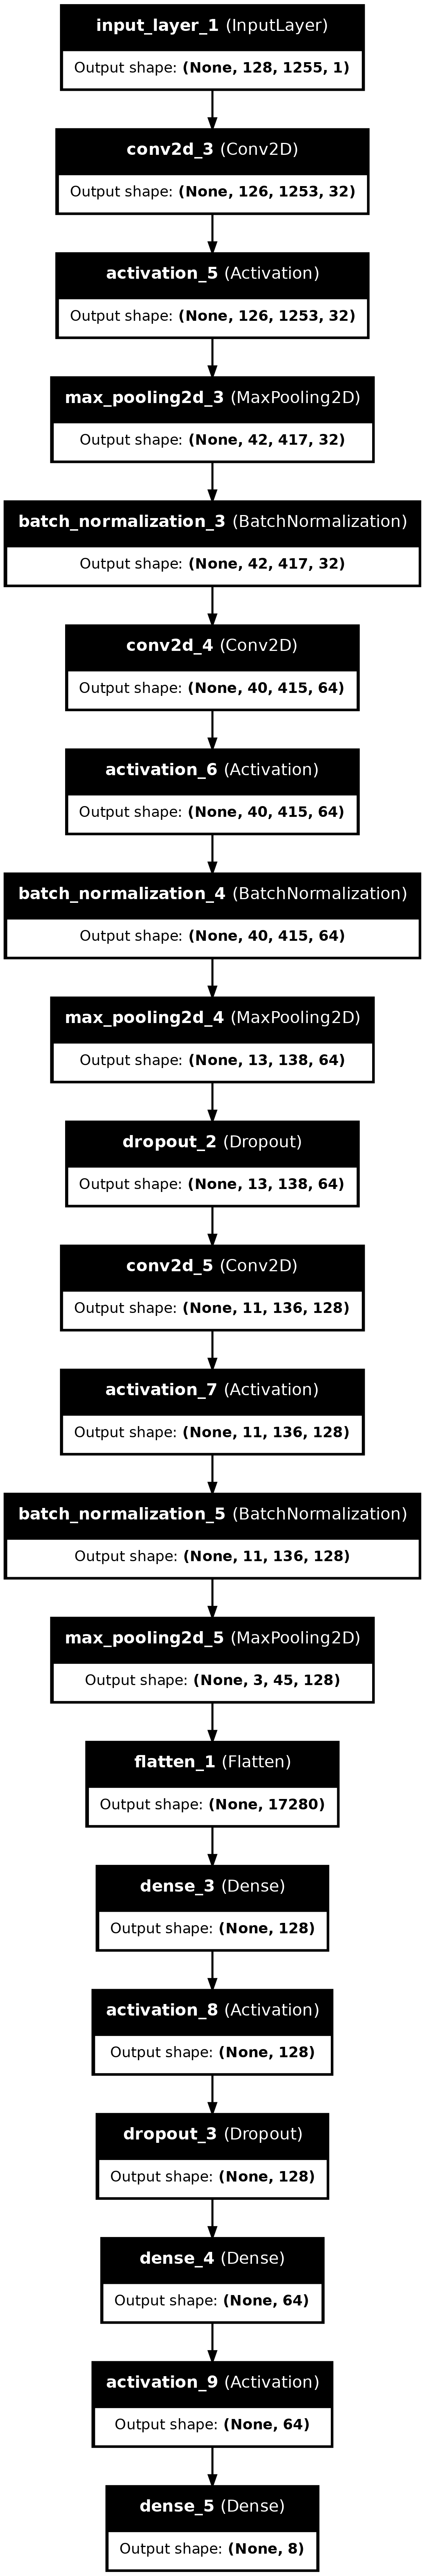

In [34]:
# Generate the plot
plot_model(model_instance.model, to_file='/home/mendu/Thesis/data/magnatagatune/model.png', show_shapes=True, show_layer_names=True)

# This command is used to display the image in Jupyter Notebook or IPython, if you're using those.
# If you're using a regular Python script, you can omit this part and just open 'model_plot.png' directly.
from IPython.display import Image, display
display(Image(filename='/home/mendu/Thesis/data/magnatagatune/model.png'))

In [ ]:
# Use the early stopping callback to halt training if validation loss doesn't improve
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Fit the model
history = model_instance.model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32
    validation_data=(X_val, y_val),
    callbacks=[early_stopper]
)

Epoch 1/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 949s 3s/step - accuracy: 0.4824 - loss: 2.1922 - val_accuracy: 0.2654 - val_loss: 4.3788
Epoch 2/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 920s 3s/step - accuracy: 0.7288 - loss: 1.4001 - val_accuracy: 0.5114 - val_loss: 1.8179
Epoch 3/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 896s 3s/step - accuracy: 0.7579 - loss: 1.1682 - val_accuracy: 0.5621 - val_loss: 2.0678
Epoch 4/100
333/333 ━━━━━━━━━━━━━━━━━━━━ 936s 3s/step - accuracy: 0.7817 - loss: 1.0066 - val_accuracy: 0.1843 - val_loss: 2.5164
Epoch 5/100


KeyboardInterrupt: 

In [ ]:
# Evaluate on validation set
val_loss, val_accuracy = model_instance.model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Evaluate on training set
train_loss, train_accuracy = model_instance.model.evaluate(X_train, y_train)
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.6611 - loss: 1.5247
Validation Loss: 1.5701756477355957, Validation Accuracy: 0.6576500535011292
333/333 ━━━━━━━━━━━━━━━━━━━━ 118s 355ms/step - accuracy: 0.6597 - loss: 1.5571
Training Loss: 1.5397459268569946, Training Accuracy: 0.6607159376144409


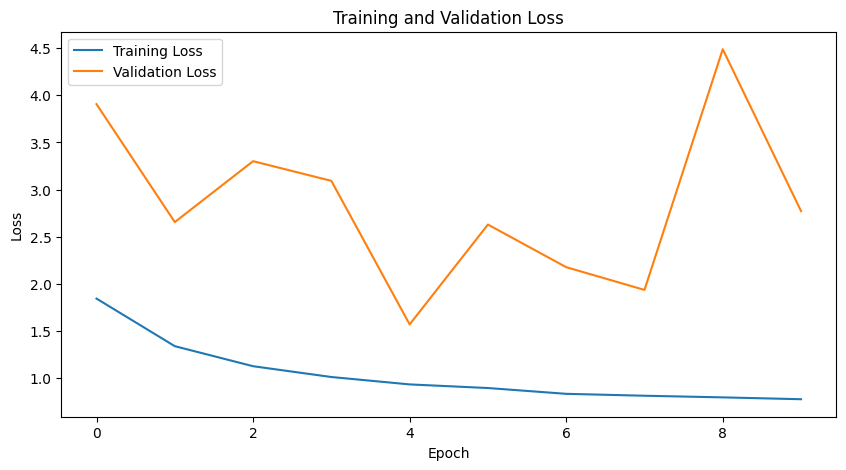

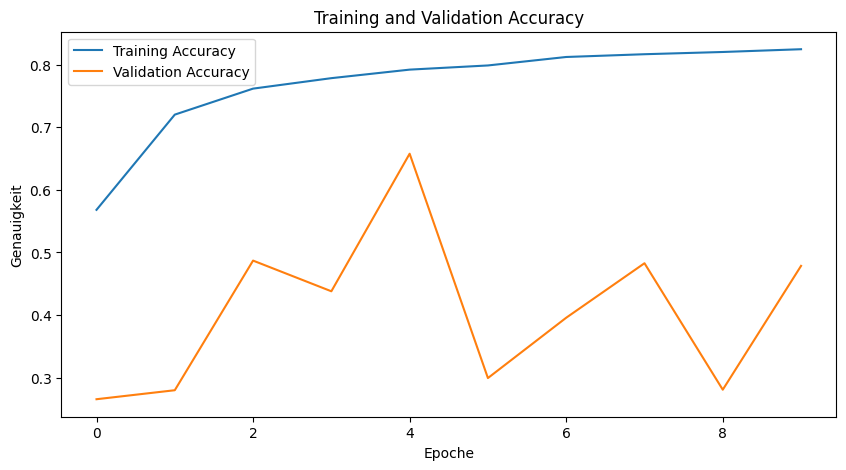

In [ ]:
# Plot a graph for training and validation loss
plt.figure(figsize=(10, 5)) # Optionally specify the figure size
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot a graph for training and validation accuracy
plt.figure(figsize=(10, 5)) # Optionally specify the figure size
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit') # If desired, you can use 'Genauigkeit' for the German word for 'Accuracy'
plt.legend()
plt.show()

In [ ]:
##change all filters to 32
# l2 regularization
ltwo_reg = 0.1

# Initialize the model
model = Sequential()

# Convolution layers
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(ltwo_reg), input_shape=( 128, 1255, 1), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# New convolutional layers
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(512, (3, 3), kernel_regularizer=l2(ltwo_reg), use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers with L2 regularization
model.add(Dense(128, kernel_regularizer=l2(ltwo_reg), use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Additional Dense layer of size 64
model.add(Dense(64, kernel_regularizer=l2(ltwo_reg), use_bias=False, name='dense_layer_with_64_units'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5)) 

# Output layer
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(ltwo_reg)))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Print the model summary
model.summary()

In [ ]:
df_new = df.reset_index(drop = True)

In [ ]:
df_new

,mp3_path,tags,caption_writing
0,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the majestic beauty of classical mu...
1,american_bach_soloists-j_s__bach_solo_cantatas...,opera,Experience the rich sound of classical eleganc...
2,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This powerful classic opera piece showcases th...
3,american_bach_soloists-j_s__bach_solo_cantatas...,opera,This atmospheric and introspective song blends...
4,lvx_nova-lvx_nova-01-contimune-30-59.mp3,electronic,This upbeat dance track features a pulsing tec...
...,...,...,...
11821,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical guitar solo piece features intr...
11822,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This beautiful classical piece features a haun...
11823,jacob_heringman-blame_not_my_lute-56-la_bressa...,classical,This classical piece features beautiful melodi...
11824,jacob_heringman-blame_not_my_lute-57-lost_is_m...,classical,This beautiful classical piece features a gent...


In [ ]:
# # Get the layer output for the custom loss
# caption_embedding_layer = model.get_layer(name='dense_layer_with_64_units').output

# # Placeholder for the true embeddings that come from your caption model
# # true_caption_embedding = K.placeholder(shape=(None, 64))

# def custom_loss_wrapper(true_embedding):
#     def custom_loss(y_true, y_pred):
#         # Standard classification loss
#         classification_loss = categorical_crossentropy(y_true, y_pred)
        
#         # Regularization loss - mean squared error between caption embeddings and dense layer output
#         regularization_loss = K.mean(K.square(caption_embedding_layer - true_embedding))
        
#         # Optional: You can scale the losses as needed
#         return classification_loss + regularization_loss
    
#     return custom_loss

# # This function will be used to provide the true embeddings when training
# def generate_true_embeddings(dataframe, batch_size):
#     while True:
#         for i in range(0, len(dataframe), batch_size):
#             batch_df = dataframe[i:i+batch_size]
#             # Compute the true caption embeddings for the batch here
#             # This example assumes you have a function that receives a batch of text and returns the embeddings
#             true_embeddings = encode_caption(encoder, roberta_model, batch_df['caption_writing'])
#             yield true_embeddings

# batch_size = 32

# # If the model has already been compiled, you need to re-compile it with the new custom loss
# true_embeddings_generator = generate_true_embeddings(df_new, batch_size)
# model.compile(optimizer='adam',
#               loss=custom_loss_wrapper(next(true_embeddings_generator)),
#               metrics=['accuracy'])

# # Print the model summary
# model.summary()

In [ ]:
# caption_embedding_layer

In [ ]:
# np.save('data/magnatagatune/data_array.npy', data)

In [ ]:
#Fitting the model and early stopping
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    # class_weight=class_weight_dict,
    callbacks=[early_stopper]
)

In [ ]:
# Save the entire model as a `.keras` zip archive.
# model.save('/home/mendu/Thesis/data/magnatagatune/saved_models/model_wmaxpool_0.1l2.keras')

## Analysing the results

In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
# last val loss and val acc
val_loss, val_accuracy = model.evaluate(X_val, y_val)
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.2409 - loss: 22.6580
333/333 ━━━━━━━━━━━━━━━━━━━━ 62s 185ms/step - accuracy: 0.2884 - loss: 22.5490
Validation Loss: 22.598712921142578, Validation Accuracy: 0.2654268741607666
Training Loss: 22.584447860717773, Training Accuracy: 0.27858686447143555
